## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%.

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)).

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

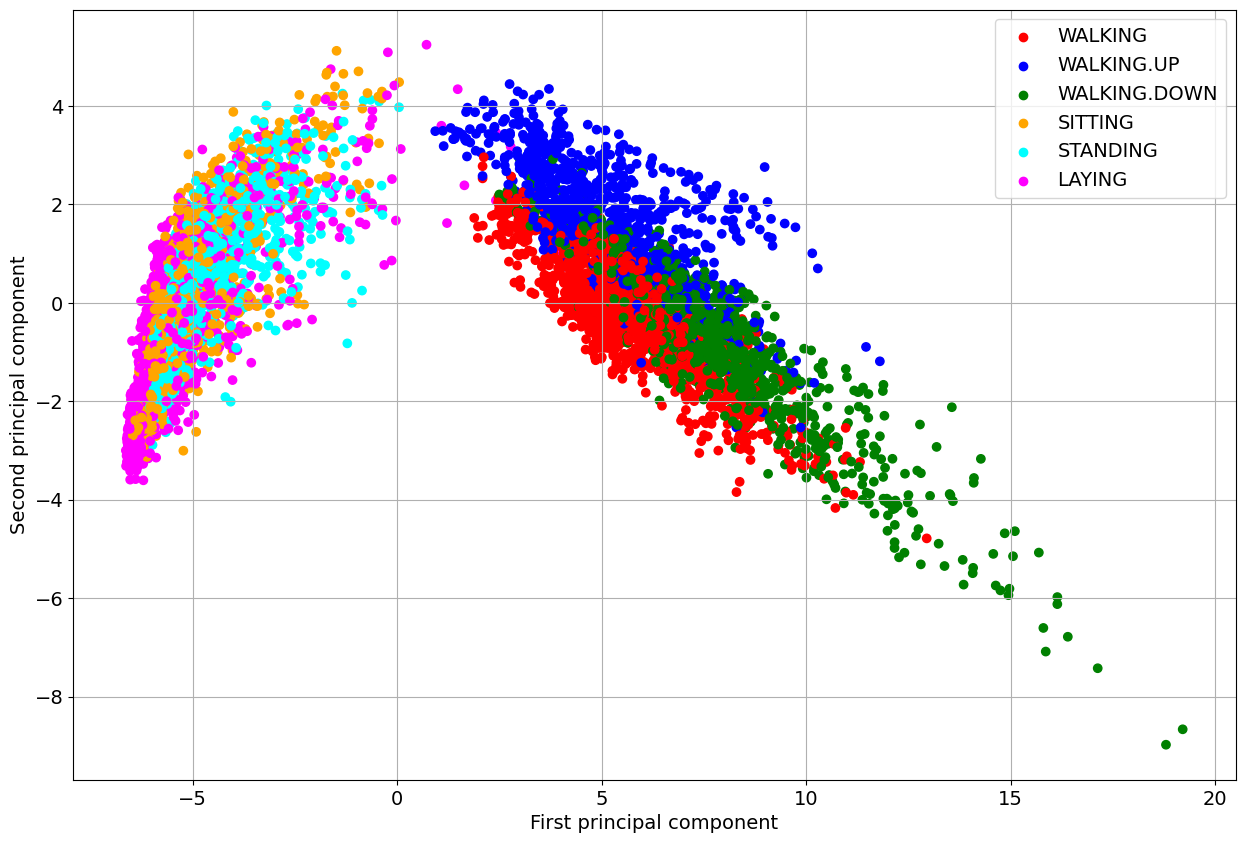

In [ ]:
X_train_with_engineered_features = np.genfromtxt("X_train.txt", invalid_raise = False)
y_train = np.genfromtxt("y_train.txt")

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0],
                x[1],
                c=colors_list[idx],
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

In [ ]:
!pip install numpy==1.2

ERROR: Could not find a version that satisfies the requirement numpy==1.2 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.21.2, 1.21.3, 1.21.4, 1.21.5, 1.21.6, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0, 1.23.1, 1.23.2, 1.23.3, 1.23.4, 1.23.5, 1.24.0, 1.24.1, 1.24.2, 1.24.3, 1.24.4, 1.25.0, 1.25.1, 1.25.2, 1.26.0, 1.26.1, 1.26.2, 1.26.3, 1.26.4, 2.0.0, 2.0.1, 2.0.2, 2.1.0rc1, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.2.0rc1, 2.2.0)
ERROR: No matching distributi

In [ ]:
!pip install pandas==1.5.2

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [76]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]


DATASET_PATH =  "UCI HAR Dataset/"


TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):

    for ind, signal_type_path in enumerate(X_signals_paths):
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals_i =np.concatenate([np.expand_dims(np.array(row.replace('  ', ' ').strip().split(' ')), 0) for row in file
            ], axis=0)
        if ind == 0:
            X_signals = np.expand_dims(X_signals_i, 0)
        else:
            X_signals = np.concatenate((X_signals, np.expand_dims(X_signals_i, 0)))
        file.close()
    print(X_signals.shape)
    return np.transpose(X_signals, (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

(9, 7352, 128)
(9, 2947, 128)


In [77]:
X_train.shape

(7352, 128, 9)

In [78]:
X_train = X_train.astype('float')

In [79]:
X_test = X_test.astype('float')
y_train = y_train.astype('float')
y_test = y_test.astype('float')

In [80]:
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [89]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep
import torch
import torch.nn as nn
import torch.nn.functional as F

dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)

dataset_test = torch.utils.data.TensorDataset(X_test, y_test)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=False)

class LSTMWithAttention(nn.Module):
    def __init__(self, n_hidden, n_classes):
        super(LSTMWithAttention, self).__init__()


        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.lstm = nn.LSTM(input_size=9, hidden_size=n_hidden, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=n_hidden, num_heads=1)
        self.layer_norm = nn.LayerNorm(n_hidden)
        self.dense = nn.Linear(n_hidden, n_classes)

    def forward(self, x):

        lstm_out, _ = self.lstm(x)
        attention_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        norm_out = self.layer_norm(attention_out + lstm_out)
        output = self.dense(norm_out[:, -1, :])

        return output

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)



model = LSTMWithAttention(n_hidden=n_hidden, n_classes=n_classes )


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_lstm(model, dataloader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_data, batch_labels in dataloader:

            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels[:, 0])

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')
    return model


In [92]:
model = train_lstm(model, data_loader_train, criterion, optimizer, 10)

Epoch [1/10], Loss: 0.1814
Epoch [2/10], Loss: 0.1760
Epoch [3/10], Loss: 0.1735
Epoch [4/10], Loss: 0.1570
Epoch [5/10], Loss: 0.1495
Epoch [6/10], Loss: 0.1521
Epoch [7/10], Loss: 0.1441
Epoch [8/10], Loss: 0.1443
Epoch [9/10], Loss: 0.1515
Epoch [10/10], Loss: 0.1496


In [85]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch_data, batch_labels in dataloader:
            outputs = model(batch_data)
            batch_labels= batch_labels[:, 0]
            loss = criterion(outputs, batch_labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_labels).sum().item()
            total_samples += batch_labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples

    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    return avg_loss, accuracy

In [93]:
avg_loss, accuracy = evaluate(model, data_loader_test, criterion)

Validation Loss: 0.3184, Accuracy: 0.8968


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [114]:
import os
import zipfile
from io import BytesIO
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image


with zipfile.ZipFile("data.zip", mode="r") as archive:
  archive.extractall("dog_breeds/")


class DogBreedDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []


        for label in os.listdir(image_folder):
            label_folder = os.path.join(image_folder, label)
            if os.path.isdir(label_folder):
                for img_file in os.listdir(label_folder):
                    self.image_paths.append(os.path.join(label_folder, img_file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = int(self.labels[idx])

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


image_folder_train = 'dog_breeds/data/train/'
image_folder_test = 'dog_breeds/data/test/'
dataset_train = DogBreedDataset(image_folder=image_folder_train, transform=transform)
dataset_test = DogBreedDataset(image_folder=image_folder_test, transform=transform)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


class DogBreedClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DogBreedClassifier, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        for param in self.vgg16.parameters():
            param.requires_grad = False
        self.vgg16.classifier[6] = nn.Linear(4096, num_classes)
        self.vgg16.classifier[6].requires_grad = True

    def forward(self, x):
        return self.vgg16(x)


num_classes = len(set(dataset_train.labels))

model = DogBreedClassifier(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for ind, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        labels = torch.tensor(labels, dtype=torch.long)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if ind > 200:
          break

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')
# Обучается, но оч долго, не успела сделать

<ipython-input-114-1d4c0384a2e8>:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


KeyboardInterrupt: 